In [6]:
# 1. 准备——引入库、定义数据目录
from pathlib import Path
import pandas as pd

DATA_DIR = Path(r"E:\Python\.vscode\datasets\shopanalyse")

# 2. 载入 orders.csv 并过滤 eval_set == 'train'
orders = pd.read_csv(
    DATA_DIR / "orders.csv",
    usecols=[
        "order_id",
        "user_id",
        "eval_set",
        "order_number",
        "order_dow",
        "order_hour_of_day",
        "days_since_prior_order",
    ]
)
# 只保留 train 集
train_orders = orders[orders["eval_set"] == "train"].reset_index(drop=True)
print(f"orders.csv 总行数: {len(orders)}, train 子集行数: {len(train_orders)}")
train_orders.head()

# 3. 载入 aisles.csv、departments.csv、products.csv
aisles     = pd.read_csv(DATA_DIR / "aisles.csv")       # aisle_id, aisle
departments= pd.read_csv(DATA_DIR / "departments.csv")  # department_id, department
products   = pd.read_csv(DATA_DIR / "products.csv")     # product_id, product_name, aisle_id, department_id

print(f"aisles: {aisles.shape}, departments: {departments.shape}, products: {products.shape}")

# 4. 合并元数据：给 products 注入 aisle 名和 department 名
products_full = (
    products
    .merge(aisles,      on="aisle_id",      how="left")
    .merge(departments, on="department_id", how="left")
)
print("合并后 products_full 示例：")
products_full.head()

# 5. 将 train_orders 与 products_full 保存到本地，方便检查
OUT_DIR = DATA_DIR  # Path(r"E:\Python\.vscode\datasets\shopanalyse")

# 保存 train_orders
train_orders.to_csv(
    OUT_DIR / "train_orders.csv",
    index=False,
    encoding="utf-8-sig"
)
print(f"Saved train_orders ({len(train_orders)} rows) to {OUT_DIR/'train_orders.csv'}")

# 保存 products_full
products_full.to_csv(
    OUT_DIR / "products_full.csv",
    index=False,
    encoding="utf-8-sig"
)
print(f"Saved products_full ({len(products_full)} rows) to {OUT_DIR/'products_full.csv'}")


orders.csv 总行数: 3421083, train 子集行数: 131209
aisles: (134, 2), departments: (21, 2), products: (49688, 4)
合并后 products_full 示例：
Saved train_orders (131209 rows) to E:\Python\.vscode\datasets\shopanalyse\train_orders.csv
Saved products_full (49688 rows) to E:\Python\.vscode\datasets\shopanalyse\products_full.csv


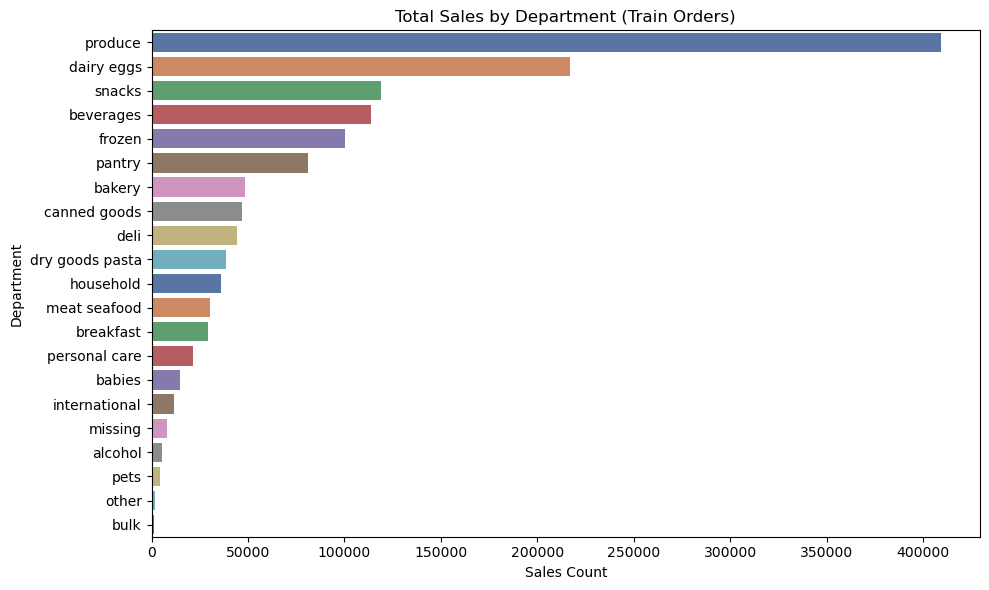

In [7]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 定义数据目录
DATA_DIR = Path(r"E:\Python\.vscode\datasets\shopanalyse")

# 2. 加载清洗后数据
train_orders    = pd.read_csv(DATA_DIR / "train_orders.csv")
products_full   = pd.read_csv(DATA_DIR / "products_full.csv")

# 3. 加载 train 明细，只要 order_id, product_id
op_train = pd.read_csv(
    DATA_DIR / "order_products__train.csv",
    usecols=["order_id", "product_id"]
)

# 4. 先筛出 train_orders 对应的明细，再关联上 department
df = (
    op_train
    .merge(train_orders[["order_id"]], on="order_id", how="inner")
    .merge(products_full[["product_id", "department"]],
           on="product_id", how="left")
)

# 5. 按 department 聚合计数
dept_counts = (
    df["department"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "department", "department": "sales_count"})
)

# 6. 绘制柱状图
plt.figure(figsize=(10, 6))
sns.barplot(data=dept_counts,
            x="sales_count",
            y="department",
            palette="deep")
plt.title("Total Sales by Department (Train Orders)")
plt.xlabel("Sales Count")
plt.ylabel("Department")
plt.tight_layout()
plt.show()


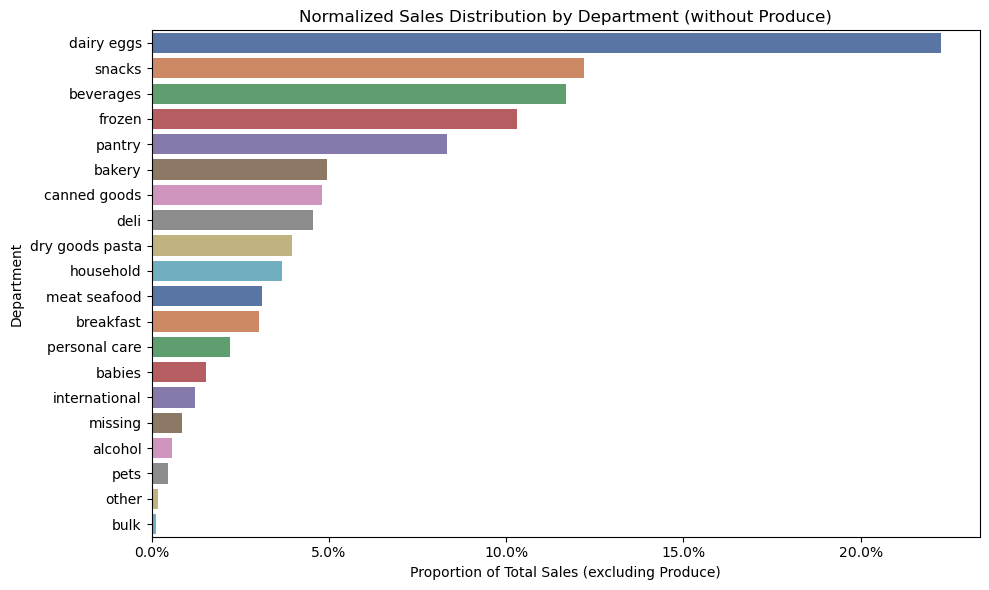

In [8]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# 1. 定义数据目录
DATA_DIR = Path(r"E:\Python\.vscode\datasets\shopanalyse")

# 2. 加载数据
train_orders  = pd.read_csv(DATA_DIR / "train_orders.csv", usecols=["order_id"])
products_full = pd.read_csv(DATA_DIR / "products_full.csv", usecols=["product_id","department"])
op_train      = pd.read_csv(
    DATA_DIR / "order_products__train.csv",
    usecols=["order_id","product_id"]
)

# 3. 关联并聚合
df = (
    op_train
    .merge(train_orders, on="order_id", how="inner")
    .merge(products_full, on="product_id", how="left")
)
dept_counts = (
    df["department"]
    .value_counts()
    .rename_axis("department")
    .reset_index(name="sales_count")
)

# 4. 排除 "Produce" 大类（不显示）
dept_counts = dept_counts[dept_counts["department"].str.lower() != "produce"]

# 5. 归一化计算
total = dept_counts["sales_count"].sum()
dept_counts["sales_pct"] = dept_counts["sales_count"] / total

# 6. 绘制百分比柱状图
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=dept_counts,
    x="sales_pct",
    y="department",
    palette="deep"
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Proportion of Total Sales (excluding Produce)")
ax.set_ylabel("Department")
ax.set_title("Normalized Sales Distribution by Department (without Produce)")
plt.tight_layout()
plt.show()


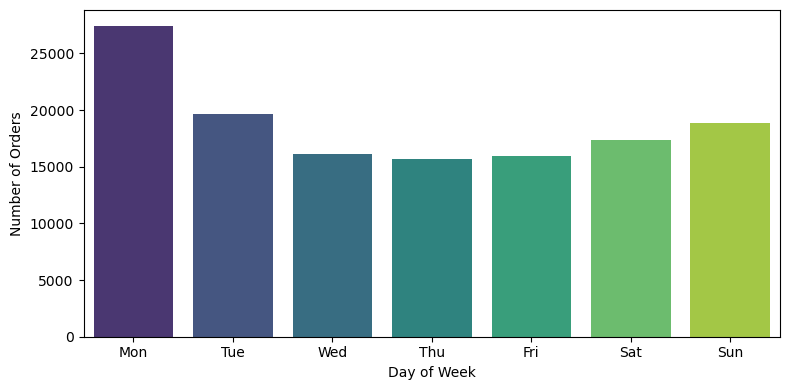

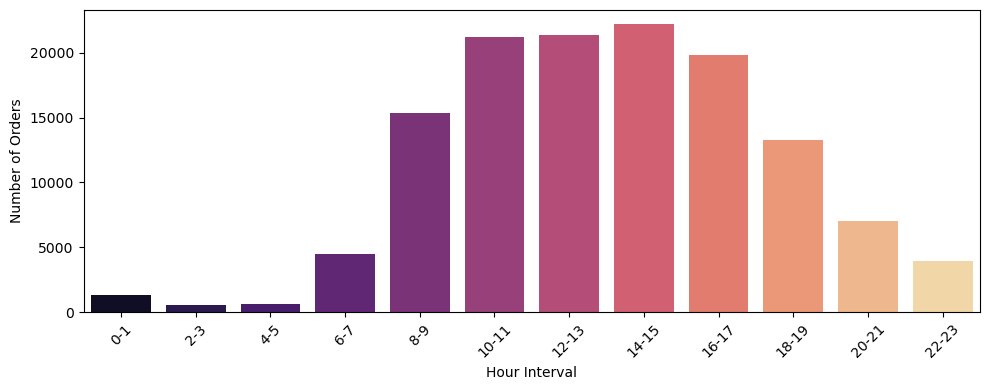

In [9]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 定义路径 & 加载 train_orders.csv
DATA_DIR     = Path(r"E:\Python\.vscode\datasets\shopanalyse")
train_orders = pd.read_csv(DATA_DIR / "train_orders.csv",
                           usecols=["order_id", "order_dow", "order_hour_of_day"])

# 2. 按星期几统计订单数（0=Mon … 6=Sun）
dow_counts = (
    train_orders["order_dow"]
    .value_counts()
    .reindex(range(7), fill_value=0)  # 确保 0-6 都有
    .rename(index={
        0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu",
        4: "Fri", 5: "Sat", 6: "Sun"
    })
)

# 3. 画一周七天的订单柱状图
plt.figure(figsize=(8, 4))
sns.barplot(x=dow_counts.index, y=dow_counts.values, palette="viridis")
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

# 4. 每 2 小时合并成一个区间
#    0–1, 2–3, …, 22–23
train_orders["hour_bin"] = (train_orders["order_hour_of_day"] // 2) * 2
train_orders["hour_bin_label"] = train_orders["hour_bin"].astype(str) + "-" + (train_orders["hour_bin"] + 1).astype(str)

# 5. 按 2h 区间统计订单数，并按区间顺序排序
hour_counts = (
    train_orders["hour_bin_label"]
    .value_counts()
    .reindex(
        [f"{h}-{h+1}" for h in range(0, 24, 2)],
        fill_value=0
    )
)

# 6. 画 24 小时（2h 间隔）订单分布柱状图
plt.figure(figsize=(10, 4))
sns.barplot(x=hour_counts.index, y=hour_counts.values, palette="magma")
plt.xlabel("Hour Interval")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
from pathlib import Path
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# ── 一、阈值配置 ───────────────────────────────────────────
DATA_DIR        = Path(r"E:\Python\.vscode\datasets\shopanalyse")
MIN_SUPPORT     = 0.01   # 最小支持度
MIN_CONFIDENCE  = 0.20   # 最小置信度
MIN_LIFT        = 1.20   # 最小提升度（可选）
MIN_CONVICTION  = 1.00   # 最小归约度（可选）
TOP_N           = 30     # 最终输出 Top-N 规则

# ── 二、加载数据 ────────────────────────────────────────────
ORDERS    = DATA_DIR / "orders.csv"
TRAIN_OP  = DATA_DIR / "order_products__train.csv"
PROD_FULL = DATA_DIR / "products_full.csv"
OUTPUT    = DATA_DIR / "rules_filtered.csv"

# 1. 只要 train 集的 order_id
train_orders = (
    pd.read_csv(ORDERS, usecols=["order_id","eval_set"])
      .query("eval_set=='train'")
      ["order_id"]
)

# 2. 加载明细和商品元数据
op    = pd.read_csv(TRAIN_OP, usecols=["order_id","product_id","add_to_cart_order"])
prods = pd.read_csv(PROD_FULL, usecols=["product_id","product_name","department"])

# ── 三、大类过滤 ────────────────────────────────────────────
df0 = (
    op.merge(train_orders, on="order_id")
      .merge(prods[["product_id","department"]], on="product_id")
)
keep_depts = (
    df0["department"]
    .value_counts(normalize=True)
    .loc[lambda s: s>=0.025]
    .index
    .tolist()
)

# ── 四、构建 transaction ───────────────────────────────────
df = (
    op.merge(train_orders, on="order_id")
      .merge(prods[["product_id","department"]], on="product_id")
)
df = df[df["department"].isin(keep_depts)]
df = df.sort_values(["order_id","add_to_cart_order"])
baskets = df.groupby("order_id")["product_id"].apply(list).tolist()

# ── 五、One-hot 编码 & Apriori ───────────────────────────────
te     = TransactionEncoder()
ohe    = te.fit(baskets).transform(baskets)
ohe_df = pd.DataFrame(ohe, columns=te.columns_)

freq_items = apriori(
    ohe_df,
    min_support=MIN_SUPPORT,
    use_colnames=True,
    verbose=1
)

# ── 六、生成规则 & 初次过滤 ─────────────────────────────────
rules = association_rules(
    freq_items,
    metric="confidence",
    min_threshold=MIN_CONFIDENCE
)

# ── 七、二次过滤 lift & conviction ───────────────────────────
rules = rules[
    (rules["lift"]      >= MIN_LIFT)     &
    (rules["conviction"]>= MIN_CONVICTION)
]

# ── 八、解码 & 输出 Top-N（保留三位小数） ────────────────────
id2name = prods.set_index("product_id")["product_name"].to_dict()
rules["ant_names"] = rules["antecedents"].apply(lambda s: tuple(id2name[i] for i in s))
rules["con_names"] = rules["consequents"].apply(lambda s: tuple(id2name[i] for i in s))

top_rules = (
    rules
    .sort_values("lift", ascending=False)
    .head(TOP_N)
    [["ant_names","con_names","support","confidence","lift","conviction"]]
)

#to_csv 时统一指定浮点格式
top_rules.to_csv(
    OUTPUT,
    index=False,
    encoding="utf-8-sig",
    float_format="%.3f"   # 所有浮点数保留三位小数
)

print(f"Done! Support≥{MIN_SUPPORT}, Conf≥{MIN_CONFIDENCE}, "
      f"Lift≥{MIN_LIFT}, Conv≥{MIN_CONVICTION} → "
      f"{len(top_rules)} rules saved to {OUTPUT}")


Processing 150 combinations | Sampling itemset size 3 2
Done! Support≥0.01, Conf≥0.2, Lift≥1.2, Conv≥1.0 → 12 rules saved to E:\Python\.vscode\datasets\shopanalyse\rules_filtered.csv


support=0.005, confidence=0.20 → rules: 68
support=0.005, confidence=0.30 → rules: 15
support=0.005, confidence=0.40 → rules: 1
support=0.005, confidence=0.50 → rules: 0
support=0.010, confidence=0.20 → rules: 15
support=0.010, confidence=0.30 → rules: 4
support=0.010, confidence=0.40 → rules: 0
support=0.010, confidence=0.50 → rules: 0
support=0.015, confidence=0.20 → rules: 7
support=0.015, confidence=0.30 → rules: 1
support=0.015, confidence=0.40 → rules: 0
support=0.015, confidence=0.50 → rules: 0
support=0.020, confidence=0.20 → rules: 1
support=0.020, confidence=0.30 → rules: 0
support=0.020, confidence=0.40 → rules: 0
support=0.020, confidence=0.50 → rules: 0
support=0.025, confidence=0.20 → rules: 1
support=0.025, confidence=0.30 → rules: 0
support=0.025, confidence=0.40 → rules: 0
support=0.025, confidence=0.50 → rules: 0
support=0.030, confidence=0.20 → rules: 0
support=0.030, confidence=0.30 → rules: 0
support=0.030, confidence=0.40 → rules: 0
support=0.030, confidence=0.50 

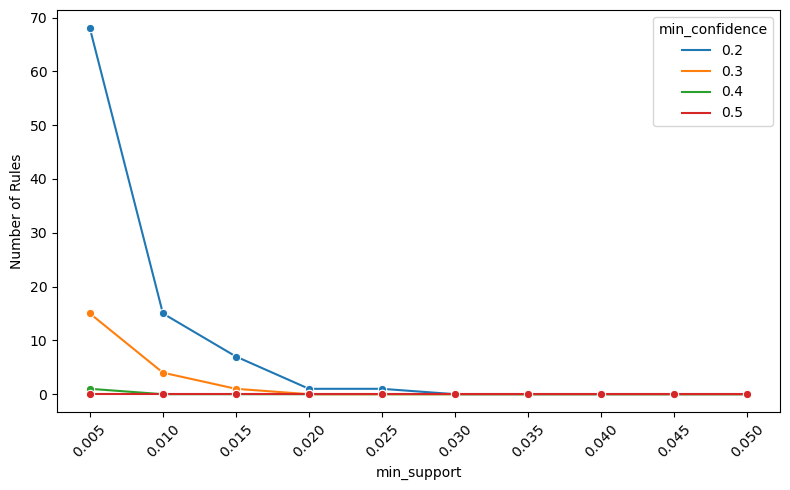

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# ── 0. 准备：读取并构建 ohe_df ──────────────────────────────
DATA_DIR    = Path(r"E:\Python\.vscode\datasets\shopanalyse")
ORDERS_FP   = DATA_DIR / "orders.csv"
TRAIN_OP_FP = DATA_DIR / "order_products__train.csv"
PROD_FP     = DATA_DIR / "products_full.csv"

# 0.1 只保留 train 订单
train_orders = (
    pd.read_csv(ORDERS_FP, usecols=["order_id","eval_set"])
      .query("eval_set == 'train'")
      ["order_id"]
)

# 0.2 载入明细 & 商品大类过滤（复用前面 keep_depts 列表）
op = pd.read_csv(TRAIN_OP_FP, usecols=["order_id","product_id","add_to_cart_order"])
prods = pd.read_csv(PROD_FP, usecols=["product_id","department"])
# （假设 keep_depts 已有；如果没有，可参考前面步骤生成）
keep_depts = ['produce','dairy','snacks','beverages','bakery']  # 示例

df = (
    op.merge(train_orders, on="order_id")
      .merge(prods, on="product_id")
      .query("department in @keep_depts")
      .sort_values(["order_id","add_to_cart_order"])
)
baskets = df.groupby("order_id")["product_id"].apply(list).tolist()

# 0.3 One-Hot 编码
te     = TransactionEncoder()
ohe    = te.fit(baskets).transform(baskets)
ohe_df = pd.DataFrame(ohe, columns=te.columns_)

# ── 1. 设置要测试的支持度与置信度列表 ───────────────────────
support_list    = np.linspace(0.005, 0.05, 10)  # 从 0.5% 到 5% 共 10 个点
confidence_list = [0.2, 0.3, 0.4, 0.5]          # 四个置信度阈值

# ── 2. 迭代计算每组阈值下的规则数 ─────────────────────────
results = []
for sup in support_list:
    # 2.1 挖出频繁项集
    freq_items = apriori(ohe_df,
                         min_support=sup,
                         use_colnames=True,
                         verbose=0)
    for conf in confidence_list:
        rules = association_rules(freq_items,
                                  metric="confidence",
                                  min_threshold=conf)
        results.append({
            "support":    sup,
            "confidence": conf,
            "n_rules":    len(rules)
        })
        print(f"support={sup:.3f}, confidence={conf:.2f} → rules: {len(rules)}")

res_df = pd.DataFrame(results)

# ── 3. 可视化：support vs n_rules（不同置信度的多条折线） ────
plt.figure(figsize=(8,5))
sns.lineplot(data=res_df,
             x="support",
             y="n_rules",
             hue="confidence",
             marker="o",
             palette="tab10")
plt.xlabel("min_support")
plt.ylabel("Number of Rules")
plt.xticks(support_list, [f"{s:.3f}" for s in support_list], rotation=45)
plt.legend(title="min_confidence")
plt.tight_layout()
plt.show()


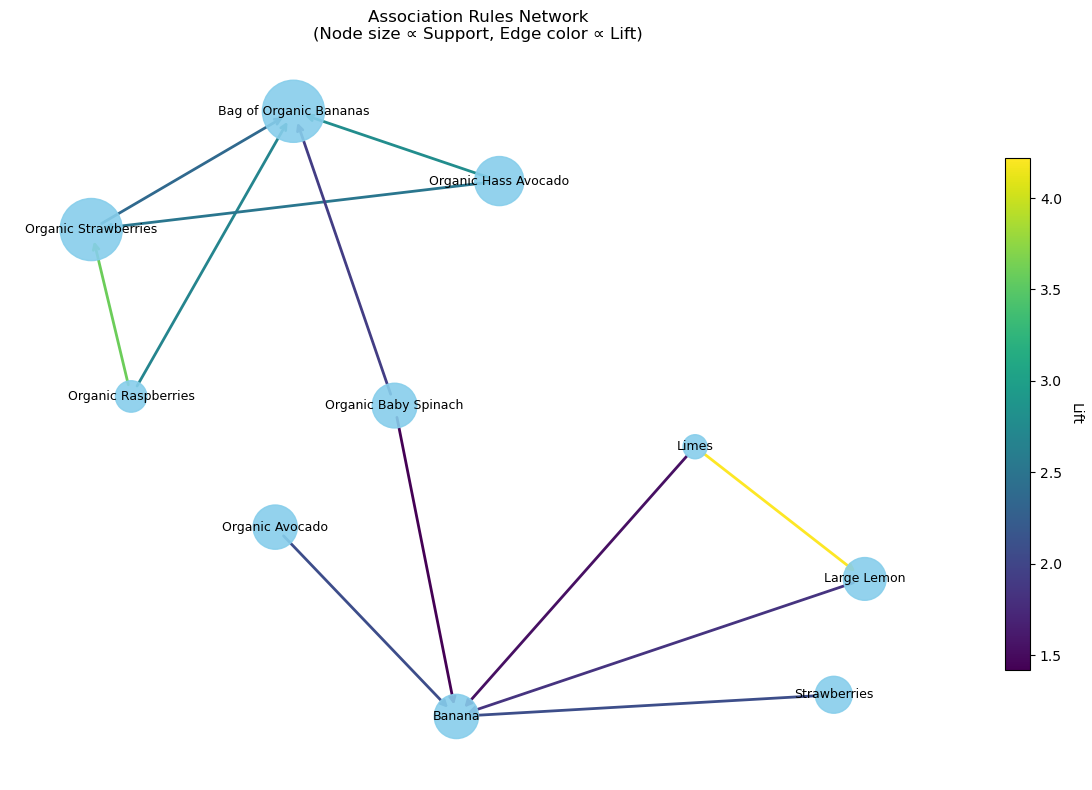

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast

# 1. 加载关联规则
rules = pd.read_csv(r"E:\Python\.vscode\datasets\shopanalyse\rules_filtered.csv")

# 2. 解析 ant_names/con_names 并取单品名称
rules["ant"] = rules["ant_names"].apply(lambda s: ast.literal_eval(s)[0])
rules["con"] = rules["con_names"].apply(lambda s: ast.literal_eval(s)[0])

# 3. 重新计算每个商品的支持度（node support）
#    从规则里提取所有商品，统计它在所有规则中的最大 support 作为节点大小指标
#    或者直接用前面 ohe_df.sum()/N 得到更精确的支持度
node_support = {}
for _, row in rules.iterrows():
    # 这里用规则的 support 近似代表该节点的“重要性”，取 max
    node_support[row["ant"]] = max(node_support.get(row["ant"], 0), row["support"])
    node_support[row["con"]] = max(node_support.get(row["con"], 0), row["support"])

# 4. 构建有向图
G = nx.DiGraph()
for _, row in rules.iterrows():
    a, b = row["ant"], row["con"]
    G.add_node(a, support=node_support[a])
    G.add_node(b, support=node_support[b])
    G.add_edge(a, b,
               support=row["support"],
               confidence=row["confidence"],
               lift=row["lift"])

# 5. 布局
pos = nx.spring_layout(G, k=1, seed=42)  # k 调整节点间距

# 6. 提取可视化属性
# 节点尺寸：按 support 线性映射到 [300, 2000]
sup_vals = [G.nodes[n]["support"] for n in G.nodes()]
min_s, max_s = min(sup_vals), max(sup_vals)
node_sizes = [300 + 1700*(s-min_s)/(max_s-min_s) for s in sup_vals]

# 边颜色：lift 映射到 colormap
edge_lifts = [G[u][v]["lift"] for u, v in G.edges()]
min_l, max_l = min(edge_lifts), max(edge_lifts)

# 7. 绘图
plt.figure(figsize=(12, 8))

# 节点
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color="skyblue",
    alpha=0.9
)

# 边
edges = nx.draw_networkx_edges(
    G, pos,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_lifts,
    edge_cmap=plt.cm.viridis,
    width=2
)

# 标签
nx.draw_networkx_labels(G, pos, font_size=9)

# 颜色条（lift）
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis,
    norm=plt.Normalize(vmin=min_l, vmax=max_l)
)
sm._A = []
cbar = plt.colorbar(sm, shrink=0.7)
cbar.set_label("Lift", rotation=270, labelpad=15)

plt.title("Association Rules Network\n(Node size ∝ Support, Edge color ∝ Lift)")
plt.axis("off")
plt.tight_layout()
plt.show()
